In [1]:
!pip install --no-index -U --find-links=/kaggle/input/tensorflow-2-15/tensorflow tensorflow==2.15.0 -q
!pip install --no-index -U --find-links=/kaggle/input/deeptables-v0-2-5/deeptables-0.2.5 deeptables==0.2.5 -q
!pip install --no-index -U --find-links=/kaggle/input/fix-deeptables/deeptables-0.2.6 deeptables==0.2.6 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-serving-api 2.16.1 requires tensorflow<3,>=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
tensorstore 0.1.66 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.0 which is incompatible.


In [2]:
import os
import math
import random
import warnings
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, polars as pl
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
from colorama import Fore, Style

import tensorflow as tf, deeptables as dt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.legacy import Adam
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets


warnings.filterwarnings('ignore')
print('TensorFlow version:',tf.__version__+',',
      'GPU =',tf.test.is_gpu_available())
print('DeepTables version:',dt.__version__)

2024-11-16 14:17:43.833263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 14:17:43.833340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 14:17:43.835299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0, GPU = True
DeepTables version: 0.2.6


In [3]:
seed = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed=seed)

In [4]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

from math import sqrt

import shutil


import os
import joblib

import scipy.stats as stats
from sklearn.metrics import mean_squared_error


from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer


pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option("display.max_rows", None)
import warnings
warnings.filterwarnings("ignore")

In [5]:
df_train = pd.read_csv('/kaggle/input/brist1d/train.csv', index_col='id', parse_dates=['time'])
df_test = pd.read_csv('/kaggle/input/brist1d/test.csv', index_col='id', parse_dates=['time'])
df_subm = pd.read_csv('/kaggle/input/brist1d/sample_submission.csv')

df_train.head()


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,bg-5:05,bg-5:00,bg-4:55,bg-4:50,bg-4:45,bg-4:40,bg-4:35,bg-4:30,bg-4:25,bg-4:20,bg-4:15,bg-4:10,bg-4:05,bg-4:00,bg-3:55,bg-3:50,bg-3:45,bg-3:40,bg-3:35,bg-3:30,bg-3:25,bg-3:20,bg-3:15,bg-3:10,bg-3:05,bg-3:00,bg-2:55,bg-2:50,bg-2:45,bg-2:40,bg-2:35,bg-2:30,bg-2:25,bg-2:20,bg-2:15,bg-2:10,bg-2:05,bg-2:00,bg-1:55,bg-1:50,bg-1:45,bg-1:40,bg-1:35,bg-1:30,bg-1:25,bg-1:20,bg-1:15,bg-1:10,bg-1:05,bg-1:00,bg-0:55,bg-0:50,bg-0:45,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00,insulin-5:55,insulin-5:50,insulin-5:45,insulin-5:40,insulin-5:35,insulin-5:30,insulin-5:25,insulin-5:20,insulin-5:15,insulin-5:10,insulin-5:05,insulin-5:00,insulin-4:55,insulin-4:50,insulin-4:45,insulin-4:40,insulin-4:35,insulin-4:30,insulin-4:25,insulin-4:20,insulin-4:15,insulin-4:10,insulin-4:05,insulin-4:00,insulin-3:55,insulin-3:50,insulin-3:45,insulin-3:40,insulin-3:35,insulin-3:30,insulin-3:25,insulin-3:20,insulin-3:15,insulin-3:10,insulin-3:05,insulin-3:00,insulin-2:55,insulin-2:50,insulin-2:45,insulin-2:40,insulin-2:35,insulin-2:30,insulin-2:25,insulin-2:20,insulin-2:15,insulin-2:10,insulin-2:05,insulin-2:00,insulin-1:55,insulin-1:50,insulin-1:45,insulin-1:40,insulin-1:35,insulin-1:30,insulin-1:25,insulin-1:20,insulin-1:15,insulin-1:10,insulin-1:05,insulin-1:00,insulin-0:55,insulin-0:50,insulin-0:45,insulin-0:40,insulin-0:35,insulin-0:30,insulin-0:25,insulin-0:20,insulin-0:15,insulin-0:10,insulin-0:05,insulin-0:00,carbs-5:55,carbs-5:50,carbs-5:45,carbs-5:40,carbs-5:35,carbs-5:30,carbs-5:25,carbs-5:20,carbs-5:15,carbs-5:10,carbs-5:05,carbs-5:00,carbs-4:55,carbs-4:50,carbs-4:45,carbs-4:40,carbs-4:35,carbs-4:30,carbs-4:25,carbs-4:20,carbs-4:15,carbs-4:10,carbs-4:05,carbs-4:00,carbs-3:55,carbs-3:50,carbs-3:45,carbs-3:40,carbs-3:35,carbs-3:30,carbs-3:25,carbs-3:20,carbs-3:15,carbs-3:10,carbs-3:05,carbs-3:00,carbs-2:55,carbs-2:50,carbs-2:45,carbs-2:40,carbs-2:35,carbs-2:30,carbs-2:25,carbs-2:20,carbs-2:15,carbs-2:10,carbs-2:05,carbs-2:00,carbs-1:55,carbs-1:50,carbs-1:45,carbs-1:40,carbs-1:35,carbs-1:30,carbs-1:25,carbs-1:20,carbs-1:15,carbs-1:10,carbs-1:05,carbs-1:00,carbs-0:55,carbs-0:50,carbs-0:45,carbs-0:40,carbs-0:35,carbs-0:30,carbs-0:25,carbs-0:20,carbs-0:15,carbs-0:10,carbs-0:05,carbs-0:00,hr-5:55,hr-5:50,hr-5:45,hr-5:40,hr-5:35,hr-5:30,hr-5:25,hr-5:20,hr-5:15,hr-5:10,hr-5:05,hr-5:00,hr-4:55,hr-4:50,hr-4:45,hr-4:40,hr-4:35,hr-4:30,hr-4:25,hr-4:20,hr-4:15,hr-4:10,hr-4:05,hr-4:00,hr-3:55,hr-3:50,hr-3:45,hr-3:40,hr-3:35,hr-3:30,hr-3:25,hr-3:20,hr-3:15,hr-3:10,hr-3:05,hr-3:00,hr-2:55,hr-2:50,hr-2:45,hr-2:40,hr-2:35,hr-2:30,hr-2:25,hr-2:20,hr-2:15,hr-2:10,hr-2:05,hr-2:00,hr-1:55,hr-1:50,hr-1:45,hr-1:40,hr-1:35,hr-1:30,hr-1:25,hr-1:20,hr-1:15,hr-1:10,hr-1:05,hr-1:00,hr-0:55,hr-0:50,hr-0:45,hr-0:40,hr-0:35,hr-0:30,hr-0:25,hr-0:20,hr-0:15,hr-0:10,hr-0:05,hr-0:00,steps-5:55,steps-5:50,steps-5:45,steps-5:40,steps-5:35,steps-5:30,steps-5:25,steps-5:20,steps-5:15,steps-5:10,steps-5:05,steps-5:00,steps-4:55,steps-4:50,steps-4:45,steps-4:40,steps-4:35,steps-4:30,steps-4:25,steps-4:20,steps-4:15,steps-4:10,steps-4:05,steps-4:00,steps-3:55,steps-3:50,steps-3:45,steps-3:40,steps-3:35,steps-3:30,steps-3:25,steps-3:20,steps-3:15,steps-3:10,steps-3:05,steps-3:00,steps-2:55,steps-2:50,steps-2:45,steps-2:40,steps-2:35,steps-2:30,steps-2:25,steps-2:20,steps-2:15,steps-2:10,steps-2:05,steps-2:00,steps-1:55,steps-1:50,steps-1:45,steps-1:40,steps-1:35,steps-1:30,steps-1:25,steps-1:20,steps-1:15,steps-1:10,steps-1:05,steps-1:00,steps-0:55,steps-0:50,steps-0:45,steps-0:40,steps-0:35,steps-0:30,steps-0:25,steps-0:20,steps-0:15,steps-0:10,steps-0:05,steps-0:00,cals-5:55,cals-5:50,cals-5:45,cals-5:40,cals-5:35,cals-5:30,cals-5:25,cals-5:20,cals-5:15,cals-5:10,cals-5:05,cals-5:00,cals-4:55,cals-4:50,cals-4:45,cals-4:40,cals-4:35,cals-4:30,cals-4:25,cals-4:20,cals-4:15,cals-4:10,cals-4:05,cals-4:00,cals-3:55,cals-3:50,cals-3:45,cals-3:40,cals-3:35,cals-3:30,cals-3:25,cals-3

In [6]:
# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

In [7]:
class CONFIG:
    hours = range(0, 6, 1)
    minutes = range(0, 60, 5)

    target_col = 'bg+1-00' # Target column name for prediction
    group_col = 'p_num'    # Column name for grouping (e.g., participant number)
    date_col = 'time'      # Column name for time data

    n_splits = 5
    seed_list = [42]
    early_stop = 200

    TRAIN_CATBOOST = False
    TRAIN_XGB = True
    TRAIN_LGB = False

    xgboost_params = {
        'random_state': 42,  # This will be updated per seed
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.025,
        'tree_method': 'hist',
        'device': 'cpu',
        'max_depth': 7,
        'min_child_weight': 200,
        'lambda': 200,
    }



In [8]:

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(CONFIG.hours, CONFIG.minutes)][:12]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(CONFIG.hours, CONFIG.minutes)][:12]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(CONFIG.hours, CONFIG.minutes)][:12]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(CONFIG.hours, CONFIG.minutes)][:12]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(CONFIG.hours, CONFIG.minutes)][:12]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(CONFIG.hours, CONFIG.minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

In [9]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = df_train[colset].interpolate(axis=1)
    df_test[colset] = df_test[colset].interpolate(axis=1)

In [10]:
imputer = SimpleImputer()

df_train[feature_cols] = imputer.fit_transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])

In [11]:
df_train['sin_hour'] = np.sin(np.pi * df_train[CONFIG.date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[CONFIG.date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[CONFIG.date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[CONFIG.date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

Learning rate schedule: 0.001 to 0.01 to 0.01


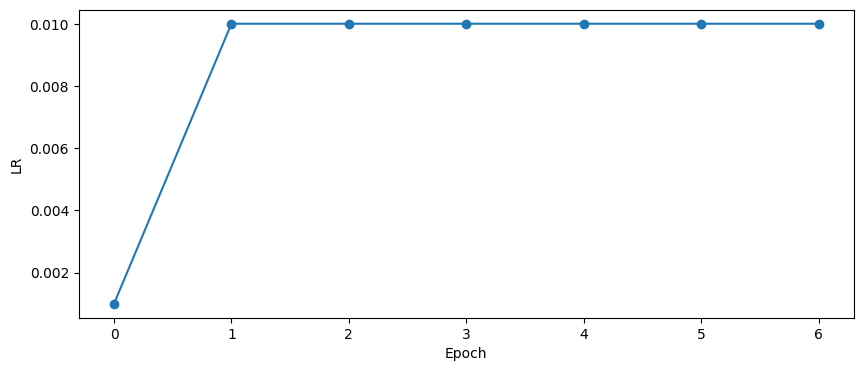

In [12]:
# https://www.kaggle.com/code/cdeotte/tensorflow-transformer-0-790/notebook
LR_START = 1e-3
LR_MAX = 1e-2
LR_MIN = 1e-2
LR_RAMPUP_EPOCHS = 1
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 7

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR_Scheduler = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [13]:
class CFG:
    epochs = 1
    batch_size = 128
    LR_Scheduler = [LR_Scheduler]
    optimizer = Adam(learning_rate=1e-3)
    
    conf = ModelConfig(auto_imputation=False,
                       auto_discrete=False,
                       auto_discard_unique=True,
                       categorical_columns='auto',
                       apply_gbm_features=True,
                       fixed_embedding_dim=True,
                       embeddings_output_dim=4,
                       embedding_dropout=0.2,
                       nets=['dnn_nets'] + ['fm_nets'] + ['cin_nets'],
                       dnn_params={
                           'hidden_units': ((1024, 0.0, True),
                                            (512, 0.0, True),
                                            (256, 0.0, True),
                                            (128, 0.0, True)),
                           'dnn_activation': 'relu',
                       },
                       stacking_op='concat',
                       output_use_bias=False,
                       optimizer=optimizer,
                       task='regression',
                       loss='auto',
                       metrics=["RootMeanSquaredError"],
                       earlystopping_patience=1,
                       )

In [14]:
def train_nn(data):

    X = data[feature_cols]
    y = data[CONFIG.target_col]
    groups = data[CONFIG.group_col]

    cv = GroupKFold(n_splits=CONFIG.n_splits)
    oof = np.zeros(len(data))
    models = []
    
    for fi, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):
        print("#"*25)
        print(f"### Fold {fi+1}/{CONFIG.n_splits} ...")
        print("#"*25)   
        K.clear_session()
        model = DeepTable(config=CFG.conf)
        model.fit(X.iloc[train_idx], y.iloc[train_idx],
                  validation_data=(X.iloc[valid_idx], y.iloc[valid_idx]),
                  callbacks=CFG.LR_Scheduler,
                  batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2)
        models.append(model)
        
        # Avoid some errors
        with K.name_scope(CFG.optimizer.__class__.__name__):
            for j, var in enumerate(CFG.optimizer.weights):
                name = 'variable{}'.format(j)
                CFG.optimizer.weights[j] = tf.Variable(var, name=name)
        CFG.conf = CFG.conf._replace(optimizer=CFG.optimizer)
        
        oof_preds = model.predict(X.iloc[valid_idx], verbose=1, batch_size=512).flatten()
        rmse = np.round(np.sqrt(np.mean((oof_preds - y.iloc[valid_idx])**2)),4)
        print(f'\nFold {fi+1} | rmse: {rmse}\n')
        if fi<CONFIG.n_splits: oof[valid_idx] = oof_preds
        else: oof[valid_idx] += oof_preds
            
    rmse = np.round(np.sqrt(np.mean((oof - y)**2)),4)
    print(f'Overall CV rmse: {rmse}\n')
    plot_model(model.get_model().model)
    return models

def infer_nn(data, models):
    return np.mean([model.predict(data, verbose=1, batch_size=512).flatten() for model in models], axis=0)

In [15]:
nn_models = train_nn(df_train)

#########################
### Fold 1/5 ...
#########################
11-16 14:18:35 I deeptables.m.deeptable.py 338 - X.Shape=(150996, 74), y.Shape=(150996,), batch_size=128, config=ModelConfig(name='conf-1', nets=['dnn_nets', 'cin_nets', 'fm_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics=['RootMeanSquaredError'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=False, auto_scale=False, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=True, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.2, stacking_op='concat', output_use_bias=False, apply_class_weight=False, optimizer=<keras.src.optimizers.legacy.adam.Adam object at 0x7832c039a8f0>, loss='auto', dnn_params={'hidden_units': ((10

11-16 14:18:35 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



11-16 14:18:35 I deeptables.m.preprocessor.py 263 - Preparing features...
11-16 14:18:36 I deeptables.m.preprocessor.py 338 - Preparing features taken 0.13408994674682617s
11-16 14:18:36 I deeptables.m.preprocessor.py 390 - Categorical encoding...
11-16 14:18:36 I deeptables.m.preprocessor.py 395 - Categorical encoding taken 0.0007784366607666016s
11-16 14:18:36 I deeptables.m.preprocessor.py 436 - Extracting GBM features...
11-16 14:18:36 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16716
[LightGBM] [Info] Number of data points in the train set: 150996, number of used features: 74
[LightGBM] [Info] Start training from score 8.224292
11-16 14:18:42 I deeptables.m.preprocessor.py 447 - Extracting gbm features taken 6.642626762390137s
11-16 14:18:43 I deeptables.m.preprocessor.py 198 - 

11-16 14:19:34 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



11-16 14:19:34 I deeptables.m.preprocessor.py 263 - Preparing features...
11-16 14:19:34 I deeptables.m.preprocessor.py 338 - Preparing features taken 0.1260826587677002s
11-16 14:19:34 I deeptables.m.preprocessor.py 390 - Categorical encoding...
11-16 14:19:34 I deeptables.m.preprocessor.py 395 - Categorical encoding taken 0.00077056884765625s
11-16 14:19:34 I deeptables.m.preprocessor.py 436 - Extracting GBM features...
11-16 14:19:34 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16747
[LightGBM] [Info] Number of data points in the train set: 142864, number of used features: 74
[LightGBM] [Info] Start training from score 8.093053
11-16 14:19:40 I deeptables.m.preprocessor.py 447 - Extracting gbm features taken 6.099892616271973s
11-16 14:19:40 I deeptables.m.preprocessor.py 198 - fit

11-16 14:20:25 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



11-16 14:20:25 I deeptables.m.preprocessor.py 263 - Preparing features...
11-16 14:20:25 I deeptables.m.preprocessor.py 338 - Preparing features taken 0.12494182586669922s
11-16 14:20:25 I deeptables.m.preprocessor.py 390 - Categorical encoding...
11-16 14:20:25 I deeptables.m.preprocessor.py 395 - Categorical encoding taken 0.0007076263427734375s
11-16 14:20:25 I deeptables.m.preprocessor.py 436 - Extracting GBM features...
11-16 14:20:25 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16611
[LightGBM] [Info] Number of data points in the train set: 143187, number of used features: 74
[LightGBM] [Info] Start training from score 8.576904
11-16 14:20:31 I deeptables.m.preprocessor.py 447 - Extracting gbm features taken 6.302797317504883s
11-16 14:20:31 I deeptables.m.preprocessor.py 198 - 

11-16 14:21:15 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



11-16 14:21:16 I deeptables.m.preprocessor.py 263 - Preparing features...
11-16 14:21:16 I deeptables.m.preprocessor.py 338 - Preparing features taken 0.12622928619384766s
11-16 14:21:16 I deeptables.m.preprocessor.py 390 - Categorical encoding...
11-16 14:21:16 I deeptables.m.preprocessor.py 395 - Categorical encoding taken 0.001085519790649414s
11-16 14:21:16 I deeptables.m.preprocessor.py 436 - Extracting GBM features...
11-16 14:21:16 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16584
[LightGBM] [Info] Number of data points in the train set: 143266, number of used features: 74
[LightGBM] [Info] Start training from score 8.316733
11-16 14:21:22 I deeptables.m.preprocessor.py 447 - Extracting gbm features taken 6.384299993515015s
11-16 14:21:22 I deeptables.m.preprocessor.py 198 - f

11-16 14:22:08 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



11-16 14:22:08 I deeptables.m.preprocessor.py 263 - Preparing features...
11-16 14:22:08 I deeptables.m.preprocessor.py 338 - Preparing features taken 0.12134313583374023s
11-16 14:22:08 I deeptables.m.preprocessor.py 390 - Categorical encoding...
11-16 14:22:08 I deeptables.m.preprocessor.py 395 - Categorical encoding taken 0.0007140636444091797s
11-16 14:22:08 I deeptables.m.preprocessor.py 436 - Extracting GBM features...
11-16 14:22:08 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16689
[LightGBM] [Info] Number of data points in the train set: 127783, number of used features: 74
[LightGBM] [Info] Start training from score 8.164584
11-16 14:22:14 I deeptables.m.preprocessor.py 447 - Extracting gbm features taken 5.505497455596924s
11-16 14:22:14 I deeptables.m.preprocessor.py 198 - 

In [16]:
X_test = df_test[feature_cols]

nn_predictions = infer_nn(X_test, nn_models)

11-16 14:22:58 I deeptables.m.deeptable.py 685 - Perform prediction...
11-16 14:22:58 I deeptables.m.preprocessor.py 244 - Transform [X]...
11-16 14:22:58 I deeptables.m.preprocessor.py 251 - transform_X taken 0.03461956977844238s
11-16 14:22:58 I deeptables.m.deepmodel.py 130 - Performing predictions...
11-16 14:22:58 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=512, shuffle=False, drop_remainder=False
8/8 [==============================] - 0s 31ms/step
11-16 14:22:58 I deeptables.m.deeptable.py 559 - predict_proba taken 0.466357946395874s
11-16 14:22:58 I deeptables.m.deeptable.py 685 - Perform prediction...
11-16 14:22:58 I deeptables.m.preprocessor.py 244 - Transform [X]...
11-16 14:22:58 I deeptables.m.preprocessor.py 251 - transform_X taken 0.035807132720947266s
11-16 14:22:58 I deeptables.m.deepmodel.py 130 - Performing predictions...
11-16 14:22:58 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDG

In [17]:
df_subm['bg+1:00'] = nn_predictions
df_subm.to_csv('deeptables_submission.csv', index=False)
print(df_subm.head())

         id    bg+1:00
0  p01_8459   8.866250
1  p01_8460   5.327205
2  p01_8461   7.848865
3  p01_8462  10.579509
4  p01_8463   6.666002
